<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 7

## NLP and Machine Learning on [travel.statsexchange.com](http://travel.stackexchange.com/) data

---

In Project 7 you'll be doing NLP and machine learning on post data from stackexchange's travel subdomain. 

This project is setup like a mini Kaggle competition. You are given the training data and when projects are submitted your model will be tested on the held-out testing data. There will be prizes for the people who build models that perform best on the held out test set!

---

## Notes on the data

The data is again compressed into the `.7z` file format to save space. There are 6 .csv files and one readme file that contains some information on the fields.

    posts_train.csv
    comments_train.csv
    users.csv
    badges.csv
    votes_train.csv
    tags.csv
    readme.txt
    
The data is located in your datasets folder:

    DSI-SF-2/datasets/stack_exchange_travel.7z
    
If you're interested in where this data came from and where to get more data from other stackexchange subdomains, see here:

https://ia800500.us.archive.org/22/items/stackexchange/readme.txt


### Recommended Utilities for .7z

- For OSX [Keka](http://www.kekaosx.com/en/) or [The Unarchiver](http://wakaba.c3.cx/s/apps/unarchiver.html). 
- For Windows [7-zip](http://www.7-zip.org/) is the standard. 
- For Linux try the `p7zip` utility.  `sudo apt-get install p7zip`.



<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 1. Use LDA to find what topics are discussed on travel.stackexchange.com.

---

Text can be found in the posts and the comments datasets. The `ParentId` column in the posts dataset indicates what the "question" post was for a given post. Comment text can be merged onto the post they are part of with the `PostId` field.

The text may have some HTML tags. BeautifulSoup has convenient ways to get rid of markup or extract text if you need to. You can also parse the strings yourself if you like.

The tags dataset has the "tags" that the users have officially given the post.

**1.1 Implement LDA against the text features of the dataset(s).**

- This can be posts or a combination of posts and comments if you want more power.
- Find optimal **K/num_topics**.

**1.2 Compare your topics to the tags. Do the LDA topics make sense? How do they compare to the tags?**


In [331]:
from gensim import corpora, models, matutils
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
import pandas as pd
import numpy as np

from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression, LinearRegression, LogisticRegressionCV
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [332]:
travel_data = pd.read_csv('stack_exchange_travel/comments_train.csv')

In [333]:
travel_data1 = pd.read_csv('stack_exchange_travel/posts_train.csv')

In [334]:
travel_df = pd.DataFrame(travel_data)

In [335]:
travel_df1 = pd.DataFrame(travel_data1)

In [336]:
travel_df1.head(3)

,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CommunityOwnedDate,CreationDate,FavoriteCount,Id,LastActivityDate,...,LastEditorDisplayName,LastEditorUserId,OwnerDisplayName,OwnerUserId,ParentId,PostTypeId,Score,Tags,Title,ViewCount
0,393.0,4.0,<p>My fiancée and I are looking for a good Car...,2013-02-25T23:52:47.953,4,NaN,2011-06-21T20:19:34.730,NaN,1,2012-05-24T14:52:14.760,...,NaN,101.0,NaN,9.0,NaN,1,8,<caribbean><cruising><vacations>,What are some Caribbean cruises for October?,361.0
1,NaN,1.0,<p>Singapore Airlines has an all-business clas...,NaN,1,NaN,2011-06-21T20:24:57.160,NaN,4,2013-01-09T09:55:22.743,...,NaN,693.0,NaN,24.0,NaN,1,8,<loyalty-programs><routes><ewr><singapore-airl...,Does Singapore Airlines offer any reward seats...,219.0
2,770.0,5.0,<p>Another definition question that interested...,NaN,0,NaN,2011-06-21T20:25:56.787,2.0,5,2012-10-12T20:49:08.110,...,NaN,101.0,NaN,13.0,NaN,1,11,<romania><transportation>,What is the easiest transportation to use thro...,340.0


In [337]:
total_travel_df = pd.concat([travel_df, travel_df1], axis=1, join='inner')
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(total_travel_df)

In [338]:
vectorizer.vocabulary_

{u'acceptedanswerid': 0,
 u'answercount': 1,
 u'body': 2,
 u'closeddate': 3,
 u'commentcount': 4,
 u'communityowneddate': 5,
 u'creationdate': 6,
 u'favoritecount': 7,
 u'id': 8,
 u'lastactivitydate': 9,
 u'lasteditdate': 10,
 u'lasteditordisplayname': 11,
 u'lasteditoruserid': 12,
 u'ownerdisplayname': 13,
 u'owneruserid': 14,
 u'parentid': 15,
 u'postid': 16,
 u'posttypeid': 17,
 u'score': 18,
 u'tags': 19,
 u'text': 20,
 u'title': 21,
 u'userdisplayname': 22,
 u'userid': 23,
 u'viewcount': 24}

In [339]:
docs = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
docs.head()

,acceptedanswerid,answercount,body,closeddate,commentcount,communityowneddate,creationdate,favoritecount,id,lastactivitydate,...,parentid,postid,posttypeid,score,tags,text,title,userdisplayname,userid,viewcount
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [340]:
vocab = {v: k for k, v in vectorizer.vocabulary_.iteritems()}
vocab

{0: u'acceptedanswerid',
 1: u'answercount',
 2: u'body',
 3: u'closeddate',
 4: u'commentcount',
 5: u'communityowneddate',
 6: u'creationdate',
 7: u'favoritecount',
 8: u'id',
 9: u'lastactivitydate',
 10: u'lasteditdate',
 11: u'lasteditordisplayname',
 12: u'lasteditoruserid',
 13: u'ownerdisplayname',
 14: u'owneruserid',
 15: u'parentid',
 16: u'postid',
 17: u'posttypeid',
 18: u'score',
 19: u'tags',
 20: u'text',
 21: u'title',
 22: u'userdisplayname',
 23: u'userid',
 24: u'viewcount'}

In [341]:
vectorizer

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [342]:
lda = models.LdaModel(
    matutils.Sparse2Corpus(X, documents_columns=False),
    # or use the corpus object created with the dictionary in the previous frame!
    # corpus, 
    num_topics  =  3,
    passes      =  20,
    id2word     =  vocab
    # or use the gensim dictionary object!
    # id2word     =  dictionary
)

In [343]:
frequency = defaultdict(int)

documents = total_travel_df

for text in documents:
    for token in text:
        frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1]
          for text in documents]

# Create gensim dictionary object
dictionary = corpora.Dictionary(texts)

# Create corpus matrix
corpus = [dictionary.doc2bow(text) for text in texts]

In [344]:
lda.print_topics(num_topics=3, num_words=7)

[(0,
  u'0.115*score + 0.115*id + 0.065*tags + 0.065*postid + 0.065*body + 0.065*viewcount + 0.065*parentid'),
 (1,
  u'0.142*creationdate + 0.081*lasteditdate + 0.081*lasteditordisplayname + 0.081*lasteditoruserid + 0.081*userdisplayname + 0.081*owneruserid + 0.081*closeddate'),
 (2,
  u'0.081*text + 0.081*posttypeid + 0.081*communityowneddate + 0.081*ownerdisplayname + 0.081*answercount + 0.081*lastactivitydate + 0.081*commentcount')]

In [345]:
lda.get_document_topics(corpus[1])

[(0, 0.11245826329556506), (1, 0.44379317240669308), (2, 0.4437485642977419)]

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 2. What makes an answer likely to be "accepted"?

---

**2.1 Build a model to predict whether a post will be marked as the answer.**

- This is a classification problem.
- You're free to use any of the machine learning algorithms or techniques we have learned in class to build the best model you can.
- NLP will be very useful here for pulling out useful and relevant features from the data. 
- Though not required, using bagging and boosting models like Random Forests and Gradient Boosted Trees will _probably_ get you the highest performance on the test data (but who knows!).


**2.2 Evaluate the performance of your classifier with a confusion matrix and accuracy. Explain how your model is performing.**

**2.3 Plot either a ROC curve or precision-recall curve (or both!) and explain what they tell you about your model.**

NOTE: You should only be predicting this for `PostTypeID=2` posts, which are the "answer" posts. This doesn't mean, however, that you can't or shouldn't use the parent questions as predictors!


In [346]:
total_travel_df.PostTypeId.head()

0    1
1    1
2    1
3    1
4    1
Name: PostTypeId, dtype: int64

In [347]:

total_travel_df['accepted'] = total_travel_df.PostTypeId.map(lambda x: 1 if x > 1  else 0)

In [348]:
total_travel_df['accepted'].unique()

array([0, 1])

In [349]:
cvec2 = CountVectorizer(stop_words = 'english', ngram_range=(1,3))

In [350]:
X2 = cvec2.fit_transform(total_travel_df['Text'])

In [351]:
y2 =  total_travel_df['accepted']

In [352]:
y2.shape, X2.shape

((41289,), (41289, 977288))

In [353]:
y2.unique()

array([0, 1])

In [354]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.4)

In [355]:
X_train2.shape, y_train2.shape

((24773, 977288), (24773,))

In [356]:
logreg2 = LogisticRegression()

In [357]:
model2 = logreg2.fit(X_train2, y_train2)

In [358]:
df_predict2 = logreg2.predict(X_test2)

In [359]:
logreg2.score(X_test2, y_test2)

0.6281181884233471

In [360]:
probabilities2 = model2.predict_proba(X_test2)

In [361]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline

def plot_roc_curve(target=False, predict_proba=False, title="Your prediction"):
    
    #    predict_proba expects a proba series/vectore of target class for plotting
    
    
    #if  (len(target) == 0   or  predict_proba == None):
    #    return "Please use all parameters!!"

     # Predict confidence scores for samples.
    #Y_score = logreg.decision_function(X)

    # [insert explanation of this section -- why do we use these?]
    # Initialize dict for false pos, true pos

    FPR = dict()
    TPR = dict()
    ROC_AUC = dict()

    # [insert explanation of this section]
    # Create ROC curve using our y=target, probablilities calculated above
    # ignore the 3rd returned result by using '_'

    FPR[1], TPR[1], _ = roc_curve(target, predict_proba)

    # compute area unde curve (auc) for given ROC
    ROC_AUC[1] = auc(FPR[1], TPR[1])

    # [insert explanation of this section -- what is being plotted?  Which elements are data driven?  
    #Which elements are purely visual?]
    # Blank plot
    plt.figure(figsize=[11,9])
    plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
    # Plot y=x line, which is like guessing
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    # label x, y axes
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('Receiver operating characteristic for %s predictions' % title, fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

In [362]:
y_test2.head()

41234    1
1302     1
8832     0
34102    1
36988    0
Name: accepted, dtype: int64

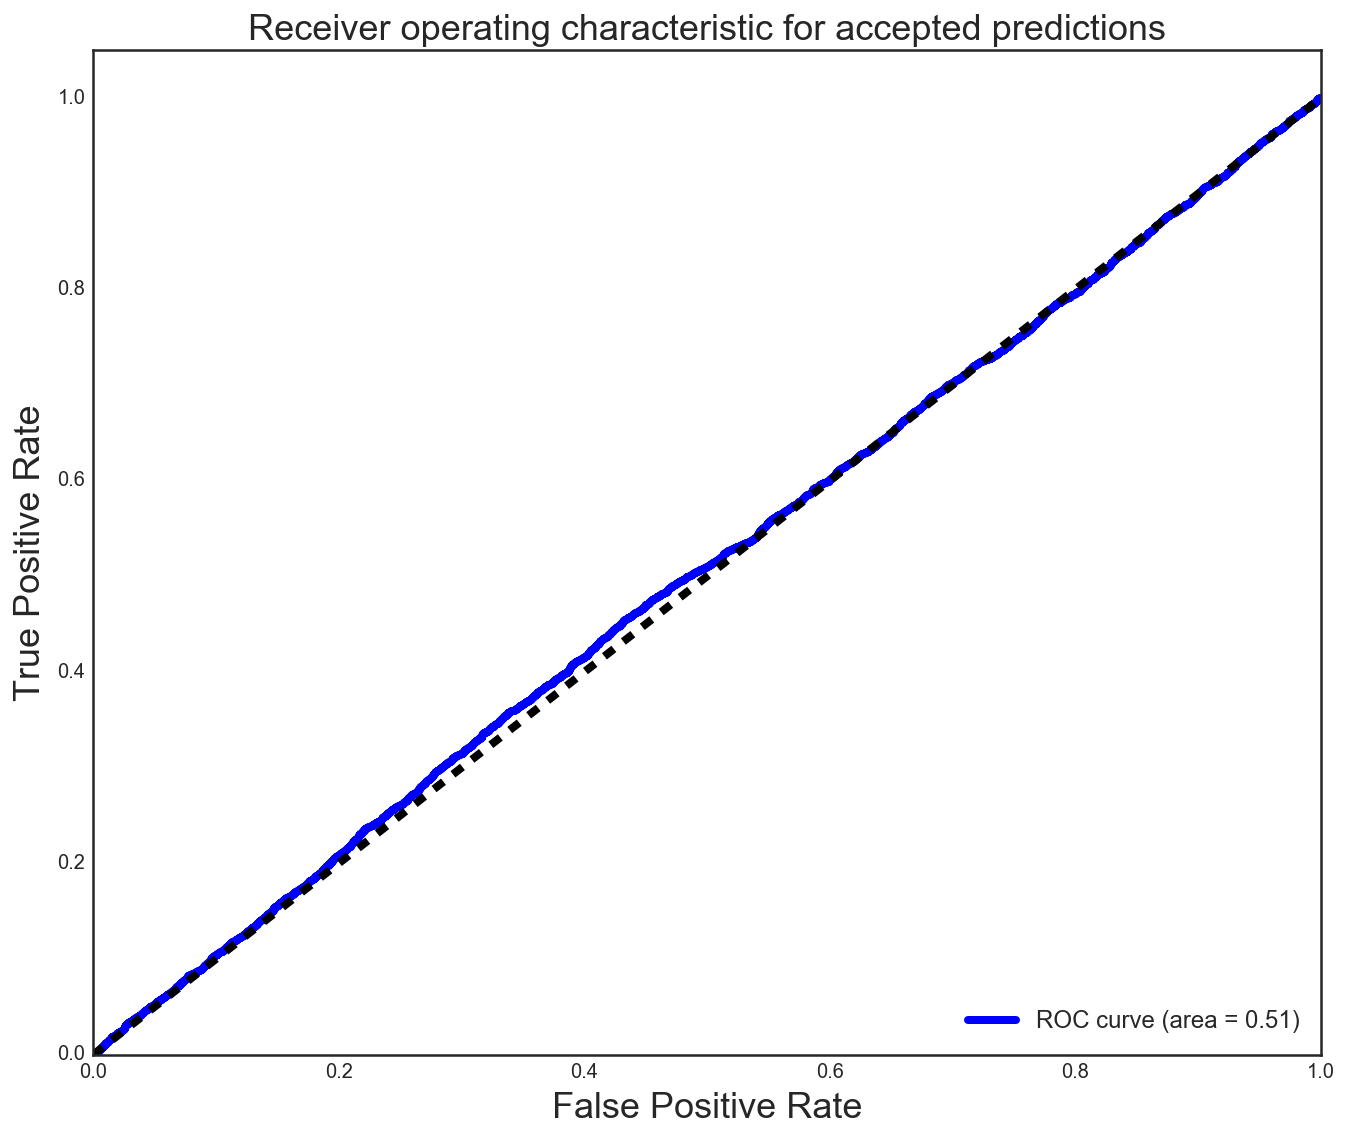

In [363]:
plot_roc_curve(target=y_test2, predict_proba=probabilities2[:,1], title="accepted")

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 3. What is the score of a post?

---

**3.1 Build a model that predicts the score of a post.**

- This is a regression problem now. 
- You can and should be predicting score for both "question" and "answer" posts, so keep them both in your dataset.
- Again, use any techniques that you think will get you the best model.

**3.2 Evaluate the performance of your model with cross-validation and report the results.**

**3.3 What is important for determining the score of a post, if anything?**


In [364]:
# Already did this for the question part. 
logreg2.score(X_test2, y_test2)

0.6281181884233471

In [365]:
cvec3 = CountVectorizer(stop_words = 'english', ngram_range=(1,3))

In [366]:
total_travel_df['Title'].dropna().head()

0         What are some Caribbean cruises for October?
1    Does Singapore Airlines offer any reward seats...
2    What is the easiest transportation to use thro...
3      Best way to get from SeaTac airport to Redmond?
4    What are must-visit destinations for the first...
Name: Title, dtype: object

In [367]:
X3 = cvec3.fit_transform(total_travel_df['Title'].dropna())

In [368]:
X3.shape[0]

13988

In [369]:
# picking up only as many elemets on y3 as is  X3.shape[0]
# so we can regress  on these 2 vars

y3 =  total_travel_df['accepted'][0:X3.shape[0]]

In [370]:
y3.shape, X3.shape

((13988,), (13988, 106665))

In [371]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.4)

In [372]:
logreg3 = LogisticRegression()

In [373]:
model3 = logreg3.fit(X_train3, y_train3)

In [374]:
logreg3.score(X_test3, y_test3)

0.69639027877055037

In [375]:
probabilities3 = model3.predict_proba(X_test3)

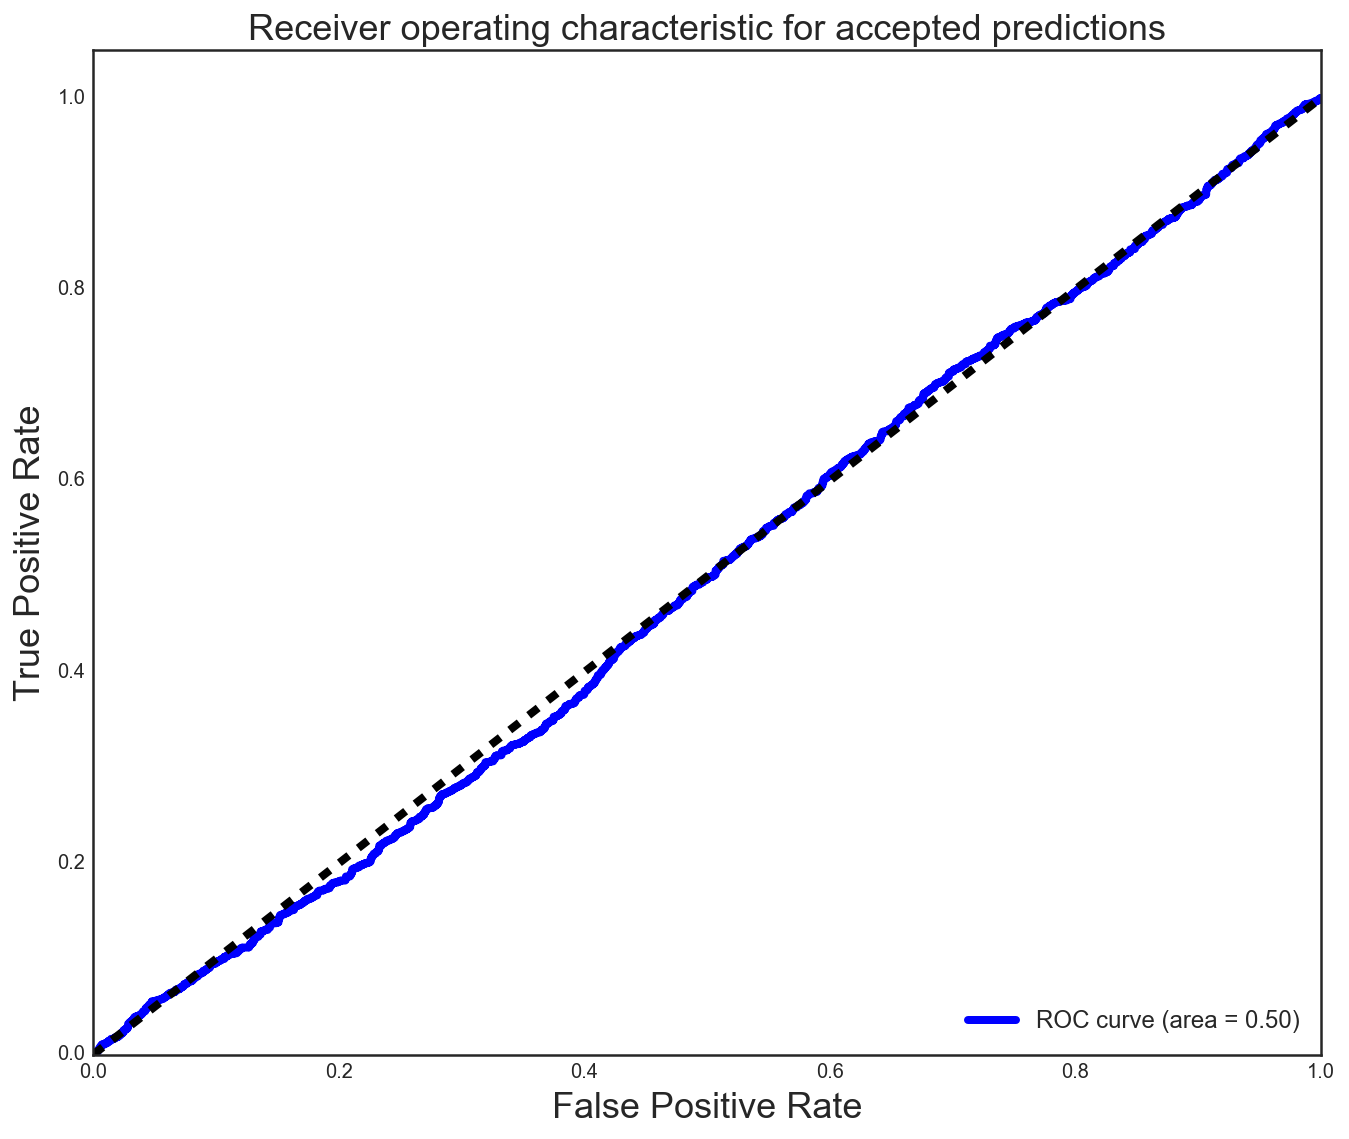

In [376]:
plot_roc_curve(target=y_test3, predict_proba=probabilities3[:,1], title="accepted")

In [377]:
scores = cross_val_score(logreg3, X3, y3, cv=5, verbose=1)
print 'CV R2s:', scores
print 'CV mean R2:', np.mean(scores)

CV R2s: [ 0.70264475  0.69907076  0.70264475  0.68930997  0.70289596]
CV mean R2: 0.699313238451


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 4. How many views does a post have?

---

**4.1 Build a model that predicts the number of views a post has.**

- This is another regression problem. 
- Predict the views for all posts, not just the "answer" posts.

**4.2 Evaluate the performance of your model with cross-validation and report the results.**

**4.3 What is important for the number of views a post has, if anything?**

In [378]:
target = 'ViewCount'

In [379]:
total_travel_df.columns

Index([u'CreationDate', u'Id', u'PostId', u'Score', u'Text',
       u'UserDisplayName', u'UserId', u'AcceptedAnswerId', u'AnswerCount',
       u'Body', u'ClosedDate', u'CommentCount', u'CommunityOwnedDate',
       u'CreationDate', u'FavoriteCount', u'Id', u'LastActivityDate',
       u'LastEditDate', u'LastEditorDisplayName', u'LastEditorUserId',
       u'OwnerDisplayName', u'OwnerUserId', u'ParentId', u'PostTypeId',
       u'Score', u'Tags', u'Title', u'ViewCount', u'accepted'],
      dtype='object')

In [380]:
total_travel_df.head(2)

,CreationDate,Id,PostId,Score,Text,UserDisplayName,UserId,AcceptedAnswerId,AnswerCount,Body,...,LastEditorUserId,OwnerDisplayName,OwnerUserId,ParentId,PostTypeId,Score,Tags,Title,ViewCount,accepted
0,2011-06-21T20:25:14.257,1,1,0,To help with the cruise line question: Where a...,NaN,12.0,393.0,4.0,<p>My fiancée and I are looking for a good Car...,...,101.0,NaN,9.0,NaN,1,8,<caribbean><cruising><vacations>,What are some Caribbean cruises for October?,361.0,0
1,2011-06-21T20:27:35.300,2,1,0,"Toronto, Ontario. We can fly out of anywhere t...",NaN,9.0,NaN,1.0,<p>Singapore Airlines has an all-business clas...,...,693.0,NaN,24.0,NaN,1,8,<loyalty-programs><routes><ewr><singapore-airl...,Does Singapore Airlines offer any reward seats...,219.0,0


In [381]:
# We will look at predicting view count over x00
limit = 150
target = 'ViewCount_over' + str(limit)
total_travel_df[target]  =  total_travel_df.ViewCount.map(lambda x: 1 if x > float(limit) 
                                                          else 0)

In [383]:
import patsy

y4, X4   = patsy.dmatrices(target + "~ Score + AnswerCount + CommentCount + FavoriteCount + \
                           PostTypeId + Score +  -1", data=total_travel_df, 
                         return_type="dataframe")

lr4 = LogisticRegression()

In [384]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.4)

In [385]:
y4.shape, X4.shape

((3522, 1), (3522, 7))

In [289]:
model4 = lr4.fit(X_train4, np.ravel(y_train4))

In [290]:
lr4.score(X_test4, y_test4)

0.88715400993612492

In [291]:
probabilities4 = model4.predict_proba(X_test4)

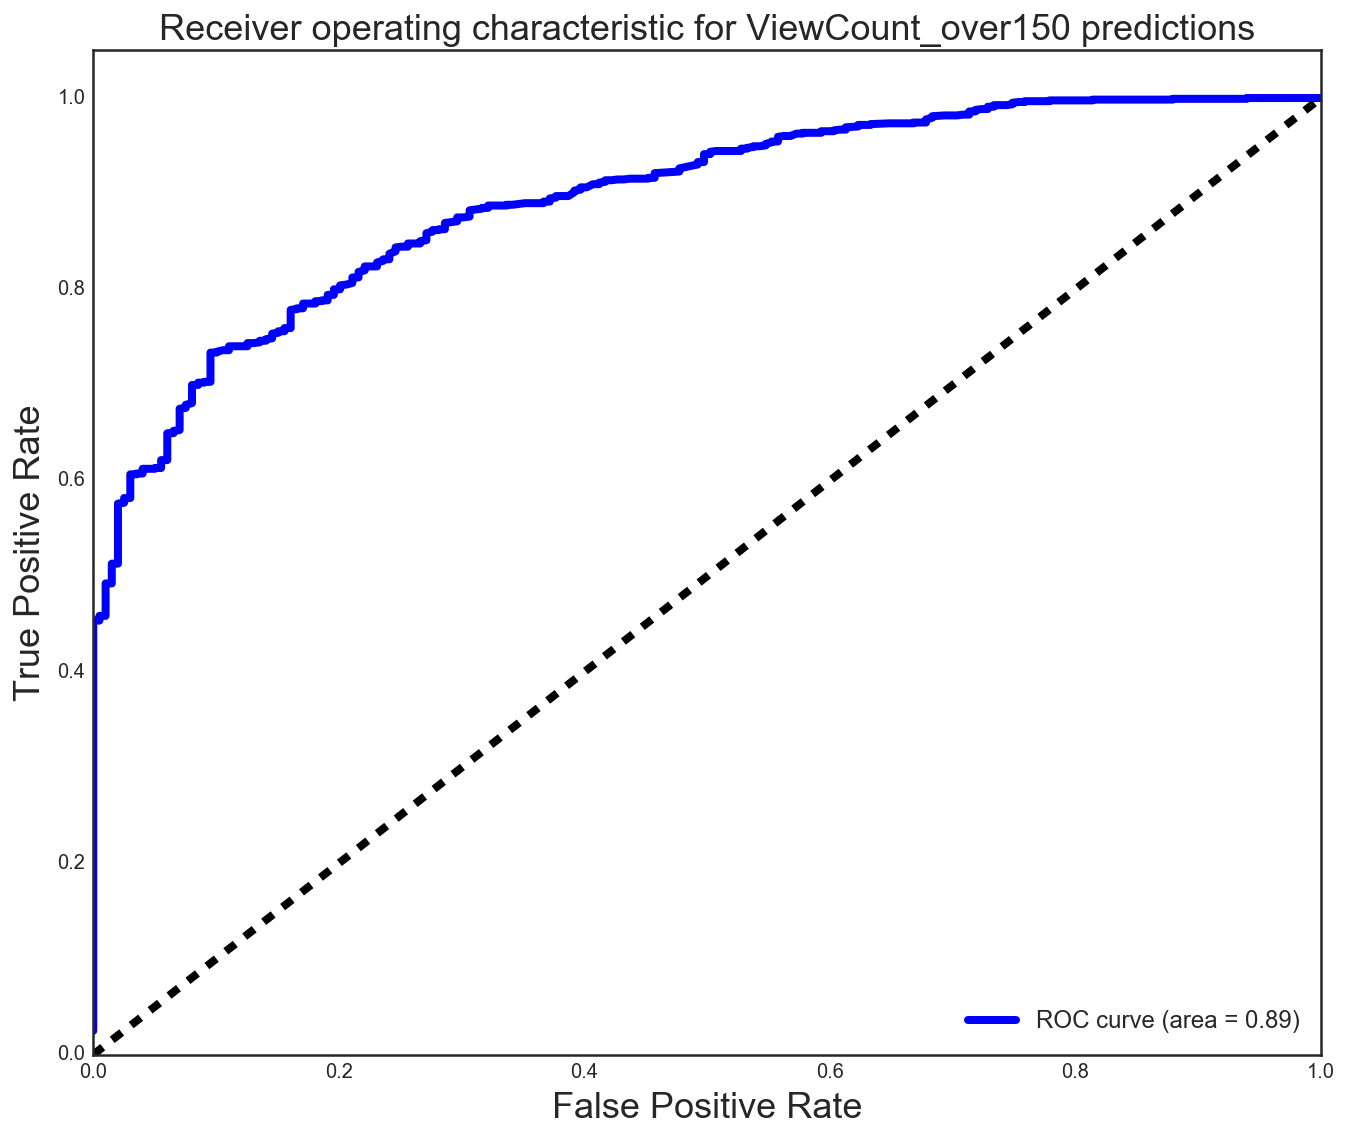

In [292]:
plot_roc_curve(target=y_test4, predict_proba=probabilities4[:,1], title=target)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 5. Build a pipeline or other code to automate evaluation of your models on the test data.

---

Now that you've constructed your three predictive models, build a pipeline or code that can easily load up the raw testing data and evaluate your models on it.

The testing data that is held out is in the same raw format as the training data you have. _Any cleaning and preprocessing that you did on the training data will need to be done on the testing data as well!_

This is a good opportunity to practice building pipelines, but you're not required to. Custom functions and classes are fine as long as they are able to process and test the new data.


In [301]:
class TravelPreprocessor(LogisticRegression):
    def __init__(self):
        self.feature_names = []
    
    def _make_viewcount_target(self, df, limit):
        
        target = 'ViewCount_over' + str(limit)
        df[target]  =  df.ViewCount.map(lambda x: 1 
                        if x > float(limit) else 0)
        return (df, target)
    
    def _set_up_train_test_lr(self, df, target):
        
        y, X   = patsy.dmatrices(target + "~ Score + AnswerCount + CommentCount + FavoriteCount + \
                           PostTypeId + Score +  -1", data=df, 
                         return_type="dataframe")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
        lr = LogisticRegression()
        return (lr, X_train, X_test, y_train, y_test)

    def fit(self, X, *args):
        return self
    
    def score(self, X, *args):
        return self

In [306]:
tprep = TravelPreprocessor()

In [307]:
lr_pipe = Pipeline(steps=[('travel_prep', tprep),
                          ('logreg', lr)])

In [324]:
# Can vary the cutoff and see the different results below
cutoff = 50
pipe_df, pipe_target = tprep._make_viewcount_target(total_travel_df, cutoff)
lr, X_train, X_test, y_train, y_test = tprep._set_up_train_test_lr(pipe_df, pipe_target)

In [325]:
pd.options.mode.chained_assignment = None  # default='warn'

In [329]:
model = lr.fit(X_train, y_train)
print lr.score(X_test, y_test)
probabilities = model.predict_proba(X_test)                

0.982256919801


/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


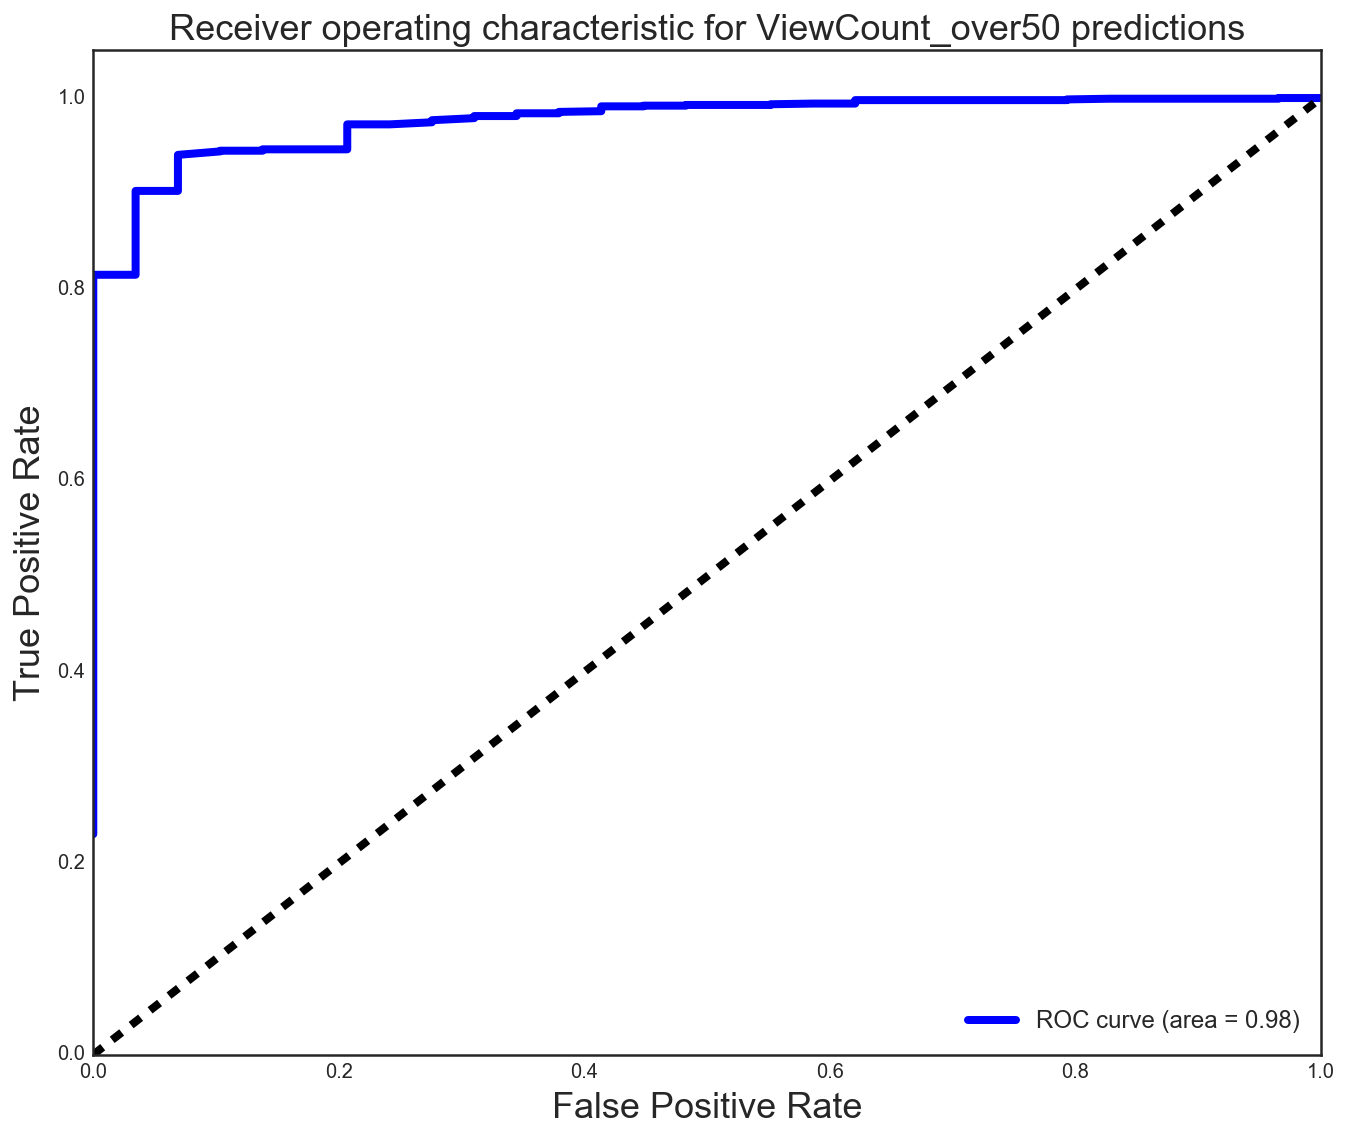

In [330]:
plot_roc_curve(target=y_test, predict_proba=probabilities[:,1], title=pipe_target)               